# Test Training with ResNet50


In [3]:
import os
import requests
import tarfile
from tqdm import tqdm  # for progress bar
from IPython.display import display, Image



In [5]:
# Function to download a file from a URL with a custom progress bar
def download_file(url, save_path):
    with requests.get(url, stream=True) as response:
        response.raise_for_status()
        total_size = int(response.headers.get('content-length', 0))
        progress = tqdm(total=total_size, unit='B', unit_scale=True, desc=os.path.basename(save_path), ncols=80)
        with open(save_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
                    progress.update(len(chunk))
        progress.close()
        

# URLs for ImageNet dataset files (replace with actual download links)
train_url = 'http://image-net.org/data/ILSVRC/2012/ILSVRC2012_img_train.tar'
val_url = 'http://image-net.org/data/ILSVRC/2012/ILSVRC2012_img_val.tar'

# Directory to save dataset files
dataset_dir = '/home/ec2-user/SageMaker/imagenet_dataset'

# Create directory if it doesn't exist
os.makedirs(dataset_dir, exist_ok=True)


# Download train dataset
train_tar_path = os.path.join(dataset_dir, 'ILSVRC2012_img_train.tar')
print(f"Downloading train dataset from {train_url}...")
download_file(train_url, train_tar_path)



# Download validation dataset
val_tar_path = os.path.join(dataset_dir, 'ILSVRC2012_img_val.tar')
print(f"Downloading validation dataset from {val_url}...")
download_file(val_url, val_tar_path)


# Extract train dataset
print(f"Extracting train dataset to {dataset_dir}...")
with tarfile.open(train_tar_path, 'r') as tar:
    tar.extractall(dataset_dir)

    
# Extract validation dataset
print(f"Extracting validation dataset to {dataset_dir}...")
with tarfile.open(val_tar_path, 'r') as tar:
    tar.extractall(dataset_dir)

print("Dataset extraction complete!")



In [ ]:
////////////////////////////////////////////////////////////////////////////////////////////////


In [5]:
import os
import tarfile
from tqdm import tqdm
import time
import shutil
import tensorflow as tf

# Define the target synset IDs and their corresponding animal names
target_species_synsets = {
    'n02129165': 'lion',
    'n02129604': 'tiger',
    'n02391049': 'zebra',
    'n02504013': 'elephant',
    'n02398521': 'hippo',
    'n02138441': 'meerkat',
    'n02480855': 'gorilla',
    'n02056570': 'king_penguin',
    'n02130308': 'cheetah',
    'n02509815': 'red_panda',
    'n02133161': 'black_bear',
    'n02497673': 'lemur',
    'n02007558': 'flamingo',
    'n02481823': 'chimpanzee',
    'n02480495': 'orangutan',
    'n02128925': 'jaguar',
    'n02510455': 'panda',
    'n02454379': 'armadillo',
    'n02117135': 'hyena',
    'n01644373': 'tree_frog'
}

def extract_images_to_folders(dataset_dir, output_dir, target_synsets, max_images_per_synset=1300, train_size=1000):
    os.makedirs(output_dir, exist_ok=True)
    
    # Create training and validation directories
    train_dir = os.path.join(output_dir, 'training')
    val_dir = os.path.join(output_dir, 'validation')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    
    start_time = time.time()
    total_extracted = 0
    total_files_to_extract = len(target_synsets) * max_images_per_synset
    
    with tqdm(total=total_files_to_extract, desc="Extracting images", unit="file") as pbar:
        for synset_id, animal_name in target_synsets.items():
            synset_tar_path = os.path.join(dataset_dir, f"{synset_id}.tar")
            
            # Create class output directories in both training and validation
            train_class_output_dir = os.path.join(train_dir, f"{synset_id}_{animal_name}")
            val_class_output_dir = os.path.join(val_dir, f"{synset_id}_{animal_name}")
            os.makedirs(train_class_output_dir, exist_ok=True)
            os.makedirs(val_class_output_dir, exist_ok=True)
            
            with tarfile.open(synset_tar_path, 'r') as tar:
                members = [m for m in tar.getmembers() if m.isfile()]
                members = members[:max_images_per_synset]
                
                for idx, member in enumerate(members):
                    if idx < train_size:
                        # Copy to training directory
                        tar.extract(member, path=train_class_output_dir)
                    else:
                        # Copy to validation directory
                        tar.extract(member, path=val_class_output_dir)
                    
                    total_extracted += 1
                    pbar.update(1)
                    
                    if total_extracted >= total_files_to_extract:
                        break
                
                if total_extracted >= total_files_to_extract:
                    break
    
    end_time = time.time()
    print(f"Extraction completed in {end_time - start_time:.2f} seconds")

# Define the dataset directory and the output directory
dataset_dir = '/home/ec2-user/SageMaker/imagenet_dataset'  
output_dir = '/home/ec2-user/SageMaker/imagenet_extracted'

# Extract images for target synsets, aiming for 1000 in training and 300 in validation per synset ID
extract_images_to_folders(dataset_dir, output_dir, target_species_synsets, max_images_per_synset=1300, train_size=1000)


Extracting images: 100%|██████████| 26000/26000 [09:07<00:00, 47.51file/s] 

Extraction completed in 547.22 seconds


In [ ]:
////////////////////////////////////////////////////////////////////////////////////////////////


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
import numpy as np
import os
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
import matplotlib.pyplot as plt

# Define image height, width, and batch size
img_height = 180
img_width = 180
batch_size = 32

# Initialize Data Augmentation
data_augmentation = Sequential(
    [
        layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
        layers.RandomBrightness(0.2),
        layers.RandomRotation(0.1),
    ]
)

# Directory for the training dataset
train_dir = '/home/ec2-user/SageMaker/imagenet_extracted/training'

# Load the training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='int'
)

# Load the validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='int'
)

# Function to save augmented images
def save_augmented_images(dataset, target_dir, target_total_count):
    class_counts = {class_name: 0 for class_name in dataset.class_names}
    
    for images, labels in dataset:
        for img, label in zip(images, labels):
            class_name = dataset.class_names[label]
            class_dir = os.path.join(target_dir, class_name)
            os.makedirs(class_dir, exist_ok=True)
            
            # Save the original image if not already saved
            if class_counts[class_name] < 1000:
                img_path = os.path.join(class_dir, f"image_{class_counts[class_name] + 1}.jpg")
                array_to_img(img).save(img_path)
                class_counts[class_name] += 1
            
            # Apply data augmentation exactly 4 times per original image
            for _ in range(4):
                augmented_img = data_augmentation(tf.expand_dims(img, 0))[0]
                img_path = os.path.join(class_dir, f"image_{class_counts[class_name] + 1}.jpg")
                array_to_img(augmented_img).save(img_path)
                class_counts[class_name] += 1
            
            if class_counts[class_name] % 500 == 0:
                print(f"{class_name}: {class_counts[class_name]} images saved")

# Create a target directory for augmented images
augmented_dir = '/home/ec2-user/SageMaker/imagenet_extracted/augmented_training'
os.makedirs(augmented_dir, exist_ok=True)

# Save augmented images to the target directory
save_augmented_images(train_ds, augmented_dir, target_total_count=5000)

# Print the number of images per class after augmentation
for class_name in train_ds.class_names:
    class_dir = os.path.join(augmented_dir, class_name)
    num_images = len(os.listdir(class_dir))
    print(f"{class_name}: {num_images} images")


Found 20000 files belonging to 20 classes.
Using 16000 files for training.
Found 20000 files belonging to 20 classes.
Using 4000 files for validation.
n02454379_armadillo: 500 images saved
n02128925_jaguar: 500 images saved
n02133161_black_bear: 500 images saved
n02129604_tiger: 500 images saved
n02480495_orangutan: 500 images saved
n02504013_elephant: 500 images saved
n02497673_lemur: 500 images saved
n02398521_hippo: 500 images saved
n02510455_panda: 500 images saved
n02007558_flamingo: 500 images saved
n02509815_red_panda: 500 images saved
n02391049_zebra: 500 images saved
n02481823_chimpanzee: 500 images saved
n02129165_lion: 500 images saved
n02117135_hyena: 500 images saved
n02138441_meerkat: 500 images saved
n02480855_gorilla: 500 images saved
n02130308_cheetah: 500 images saved
n02056570_king_penguin: 500 images saved
n01644373_tree_frog: 500 images saved
n02133161_black_bear: 1000 images saved
n02454379_armadillo: 1000 images saved
n02128925_jaguar: 1000 images saved
n02497673

In [ ]:
////////////////////////////////////////////////////////////////////////////////////////////////

In [9]:
# Load ResNet50 pretrained model without top layers
resnet50_model = tf.keras.applications.ResNet50(
    weights='imagenet', 
    include_top=False, 
    input_shape=(img_height, img_width, 3)
)
resnet50_model.trainable = False

# Define the number of classes
num_classes = len(train_ds.class_names)

# Create the model
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = resnet50_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes)(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Prefetch data for better performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


In [12]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
  4/500 [..............................] - ETA: 17:24 - loss: 2.2997 - accuracy: 0.3438

KeyboardInterrupt: 

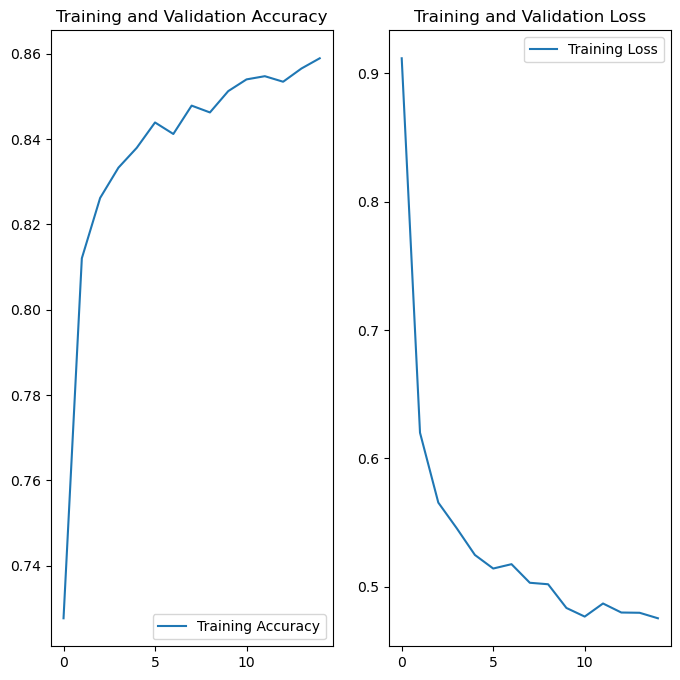

In [27]:
# Visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()